In [30]:
import numpy as np
import numpy.testing as npt
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.collections import PatchCollection
import scipy.spatial, scipy.linalg
import scipy.sparse.linalg
from scipy.misc import logsumexp
from scipy.cluster.hierarchy import linkage, dendrogram
import itertools as it
from cvxopt.solvers import qp 
from cvxopt import matrix
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
%matplotlib inline


In [36]:
class svm_smo(): 
    
    def __init__(self, kernel,C):
        self.kernel = kernel
        self.c = C
        self.min_alpha = 1e-5

    def getkernel(self, X, Y=None):
        n= len(X)
        n2 = n
        if(Y==None):
            X2=np.array(X)
            x2=len(X2)
            n2 = n
        else: 
            X2 = Y
            n2 = len(X2)
 
        if((self.kernel =='gaussian') or (self.kernel ==['gaussian'])):
            w = self.kp
            X1 = (X**2).sum(1).reshape(n,1)*np.ones((n,n2))
            U1 = (X2**2).sum(1).reshape(1,n2) * np.ones([n,n2])
            D = X1 - 2*(X.dot(X2.T)) + U1
            K = np.exp(-D/(2*w**2))
        elif((self.kernel =='polynomial') or (self.kernel ==['polynomial'])):
            p= self.kp
            K = (np.dot(X,X2.T)+1)**p
        elif((self.kernel =='linear') or (self.kernel ==['linear'])):
            K = np.dot(X,X2.T)
        else:
            raise AssertionError("Choose from ['gaussian','polynomial','linear']")
        return K
    
    
    def fx(self,X1,X2,Y):
        K=self.getkernel(X1,X2)
        alpY = (Y*self.alpha).reshape(len(self.alpha),1)
        return np.dot(K,alpY)+self.b#np.sign(np.dot(K,alpY)+self.b)
    
    def _compute_box_constraints(self, i, j, Y, alpha, C):
        
        if(Y[i]==Y[j]):
            L = np.max([0,alpha[i]+alpha[j]-C])
            H = np.min([C,alpha[i]+alpha[j]])
        else:
            L = np.max([0,alpha[j]-alpha[i]])
            H = np.min([C,C+alpha[j]-alpha[i]])
        return L, H 
    
    
    def _update_parameters(self, E_i, E_j, i, j, K, Y, alpha, b, C):
        L, H = self._compute_box_constraints( i, j, Y, alpha, C)
        if(L==H):
            return alpha, b, 0
        kappa = 2*K[i,j] -K[i,i] -K[j,j]
        if(kappa>=0):
            return alpha, b, 0
        
        aph2_new= alpha[j]-Y[j]*(E_i-E_j)/kappa

        if(aph2_new>H):
            aph2_new=H
        elif(aph2_new<L):
            aph2_new=L
           
        aph1_new = alpha[i]+Y[i]*Y[j]*(alpha[j]-aph2_new)
        if(np.abs(alpha[j]-aph2_new)<0.0005):
            return alpha, b, 0
        
        alpha_new = np.array(alpha)
        alpha_new[i]= aph1_new
        alpha_new[j]= aph2_new
        
        new_b = self._compute_updated_b( E_i, E_j, i, j, K, Y, alpha, alpha_new, b, C)
            
        return alpha_new, new_b, 1
    
    
    def _compute_updated_b(self, E_i, E_j, i, j, K, Y, alpha_old, alpha_new, b_old, C):
        b1 = b_old+E_i+Y[i]*(alpha_new[i]-alpha_old[i])*K[i,i]+Y[j]*(alpha_new[j]-alpha_old[j])*K[i,j]
        b2 = b_old+E_j+Y[i]*(alpha_new[i]-alpha_old[i])*K[i,j]+Y[j]*(alpha_new[j]-alpha_old[j])*K[j,j]
        new_b=(b1+b2)/2
        
        if((alpha_new[i]>0)and(alpha_new[i]<C)):
            new_b = b1
        if((alpha_new[j]>0)and(alpha_new[j]<C)):
            new_b = b2
        
        return new_b
     
        
    def fit(self, X, Y):
        #self.X_fit = X
        N= len(X)
        rang=np.arange(N)
        K = self.getkernel(X)
        self.alpha = np.zeros(N)
        self.b = 0
        P=1000
        tol = 0.03
        p=0
        
        while(p<P):
            a=0
            for i in range(N):
                Ei = self.fx(X[i].reshape(1,len(X[i])),X,Y)-Y[i]
                if (((Y[i]*Ei < -tol) and (self.alpha[i] < self.c)) or ( (Y[i]*Ei > tol) and (self.alpha[i] > 0))):
                    j=np.random.choice(np.setdiff1d(rang, np.array([i])),1)[0]
                    Ej = self.fx(X[j].reshape(1,len(X[i])),X,Y)-Y[j]
                    self.alpha, self.b, updated=self._update_parameters( Ei[0,0], Ej[0,0], i, j, K, Y, self.alpha, self.b, self.c)
                    a = a+updated
                
            if(a==0):        
                p=p+1
            else:
                p=0

        self.b=0.0
        alp_idx = \
            self.alpha > self.min_alpha
        self.SV= X[alp_idx]
        self.y = Y[alp_idx]
        self.alpha = self.alpha[alp_idx]
        self.b = np.mean(self.y - self.fx(self.SV,self.SV,self.y)[:,0])
            
                
                
        #f=self.fx(X,X,Y)*Y.reshape(len(Y),1)
        #self.SV= X[np.where(np.abs(f[:,0]-1)<0.0001)[0]]#0.0001
        #self.y = Y[np.where(np.abs(f[:,0]-1)<0.0001)[0]]
        #self.alpha = self.alpha[np.where(np.abs(f[:,0]-1)<0.0001)[0]]
        
    def predict(self, X):
        return np.sign(self.fx(X,self.SV,self.y)[:,0])

In [37]:

np.random.seed(1)
X_tr = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
Y_tr = np.array([1] * 30 + [-1] * 30)
X_te = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
Y_te = np.array([1] * 30 + [-1] * 30)
C = svm_smo(kernel='linear', C=1.)
C.fit(X=X_tr, Y=Y_tr)
Y_pred = C.predict(X_te)
loss = float(np.sum(np.sign(Y_te) != np.sign(Y_pred)))/float(len(Y_te))
print('test case loss', loss)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


test case loss 0.11666666666666667


In [25]:
C = svm_smo(kernel='linear', C=1.)
res2 = C._update_parameters(1.0, 0.5, 0, 1, np.array([[1.0, 0.3], [0.3, 1.0]]), np.array([-1, +1]), np.array([0.4, -0.5]), 1.2, 0.1)
res3 = C._update_parameters(1.0, 2.0, 0, 1, np.array([[1.0, 0.3], [0.3, 1.0]]), np.array([-1, +1]), np.array([0.4, -0.5]), 1.2, 0.1)
#self.assertTrue((np.allclose(res2[0], [0.1, -0.8]) and
#                 np.allclose(res2[1], 2.41, atol=1e-3) and
#                 np.allclose(res3[0], [0.9, 0.0]) and
#                 np.allclose(res3[1], 2.7, atol=1e-3)),
#                msg='_update_parameters: Error found.')

In [26]:
res2

(array([ 0.1, -0.8]), 2.4100000000000001, 1)

In [27]:
res3

(array([ 0.9,  0. ]), 2.7000000000000002, 1)

In [38]:
def plot_svm_2d(X, y, model):
    n=len(X)
    plt.figure(figsize = (6, 6))
    plt.plot(X[y ==  1,0], X[y ==  1,1], 'ro')
    plt.plot(X[y == -1,0], X[y == -1,1], 'bo')
    plt.plot(model.SV[:,0],model.SV[:,1],'kx')
    a = np.linspace(np.min(X[:,0])-1, np.max(X[:,0])+1, n)
    b = np.linspace(np.min(X[:,1])-1, np.max(X[:,1])+1, n)
    A, B = np.meshgrid(a,b)
    mesh_z = np.zeros((n, n))
    for y in range(n):
        for x in range(n):
            mesh_z[y, x] = model.fx(np.array([a[x], b[y]]).reshape(1,2),model.SV,model.y)
    plt.contour(A, B, mesh_z, 0)

In [9]:
class svm_qp():
    def __init__(self, kernel,C):
        self.kernel = kernel
        self.c = C
        self.min_alpha = 1e-5
    def getkernel(self, X, Y=None):
        n= len(X)
        n2 = n
        if(Y==None):
            X2=np.array(X)
            x2=len(X2)
            n2 = n
        else: 
            X2 = Y
            n2 = len(X2)
 
        if((self.kernel =='gaussian') or (self.kernel ==['gaussian'])):
            w = self.kp
            X1 = (X**2).sum(1).reshape(n,1)*np.ones((n,n2))
            U1 = (X2**2).sum(1).reshape(1,n2) * np.ones([n,n2])
            D = X1 - 2*(X.dot(X2.T)) + U1
            K = np.exp(-D/(2*w**2))
        elif((self.kernel =='polynomial') or (self.kernel ==['polynomial'])):
            p= self.kp
            K = (np.dot(X,X2.T)+1)**p
        elif((self.kernel =='linear') or (self.kernel ==['linear'])):
            K = np.dot(X,X2.T)
        else:
            raise AssertionError("Choose from ['gaussian','polynomial','linear']")
        return K
    
    def fx(self,X1,X2,Y):
        K=self.getkernel(X1,X2)
        alpY = (Y*self.alpha).reshape(len(self.alpha),1)
        return np.dot(K,alpY)+self.b#np.sign(np.dot(K,alpY)+self.b)
    
        
    def fit(self, X, Y):
        #self.X_fit = X
        N= len(X)
        K = self.getkernel(X)
        P = matrix(np.outer(Y, Y) * K)
        q = matrix(-1 * np.ones(N))

        G_std = matrix(np.diag(np.ones(N) * -1))
        h_std = matrix(np.zeros(N))

        # a_i \leq c
        G_slack = matrix(np.diag(np.ones(N)))
        h_slack = matrix(np.ones(N) * self.c)

        G = matrix(np.vstack((G_std, G_slack)))
        h = matrix(np.vstack((h_std, h_slack)))

        A = matrix(np.ones(N)*Y, (1, N))
        b = matrix(0.0)

        solution = qp(P, q, G, h, A, b)
        self.alpha=np.ravel(solution['x'])
#########################
        self.b=0.0
        alp_idx = \
            self.alpha > self.min_alpha
        self.SV= X[alp_idx]
        self.y = Y[alp_idx]
        self.alpha = self.alpha[alp_idx]
        self.b = np.mean(self.y - self.fx(self.SV,self.SV,self.y)[:,0])
        
    def predict(self, X):
        return np.sign(self.fx(X,self.SV,self.y)[:,0])

In [105]:
a = \
    [1,2,3,4] > [2,2,2,2]

In [106]:
a

False

     pcost       dcost       gap    pres   dres
 0: -1.3537e+01 -1.2531e+02  6e+02  3e+00  7e-15
 1: -8.1875e+00 -7.2269e+01  1e+02  3e-01  4e-15
 2: -4.1308e+00 -1.5589e+01  2e+01  4e-02  3e-15
 3: -4.4316e+00 -7.3026e+00  4e+00  8e-03  2e-15
 4: -4.8685e+00 -5.5850e+00  8e-01  1e-03  2e-15
 5: -5.0981e+00 -5.2186e+00  1e-01  1e-04  2e-15
 6: -5.1450e+00 -5.1505e+00  6e-03  4e-06  2e-15
 7: -5.1471e+00 -5.1472e+00  1e-04  6e-08  2e-15
 8: -5.1471e+00 -5.1471e+00  1e-06  6e-10  2e-15
Optimal solution found.
test case loss 0.11666666666666667


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


test case loss 0.11666666666666667


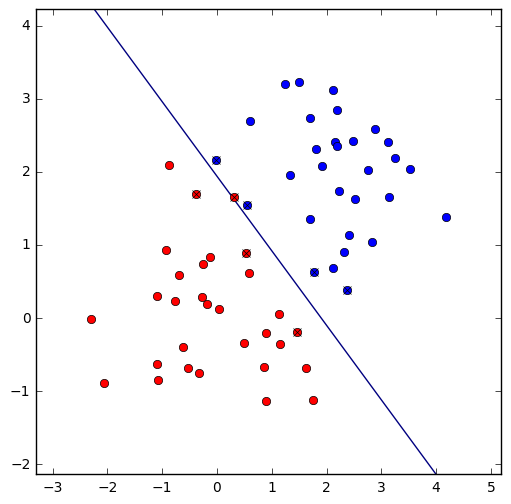

In [107]:
C = svm_qp(kernel='linear', C=1.)
np.random.seed(1)
X_tr = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
Y_tr = np.array([1] * 30 + [-1] * 30)
X_te = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
Y_te = np.array([1] * 30 + [-1] * 30)
C.fit(X=X_tr, Y=Y_tr)
Y_pred = C.predict(X_te)
loss = float(np.sum(np.sign(Y_te) != np.sign(Y_pred)))/float(len(Y_te))
print('test case loss', loss)

plot_svm_2d(X_tr, Y_tr, C)
print('test case loss', loss)



In [108]:
C.b

2.5707771405690685

In [16]:

np.random.seed(1)
X_tr = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
Y_tr = np.array([1] * 30 + [-1] * 30)
X_te = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
Y_te = np.array([1] * 30 + [-1] * 30)
C = svm_smo(kernel='linear', C=1.)
C.fit(X=X_tr, Y=Y_tr)
Y_pred = C.predict(X_te)
loss = float(np.sum(np.sign(Y_te) != np.sign(Y_pred)))/float(len(Y_te))
print('test case loss', loss)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


test case loss 0.5


In [17]:
Y_pred

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.])

In [18]:
np.sign(Y_te)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [19]:
C.SV

array([], shape=(0, 2), dtype=float64)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


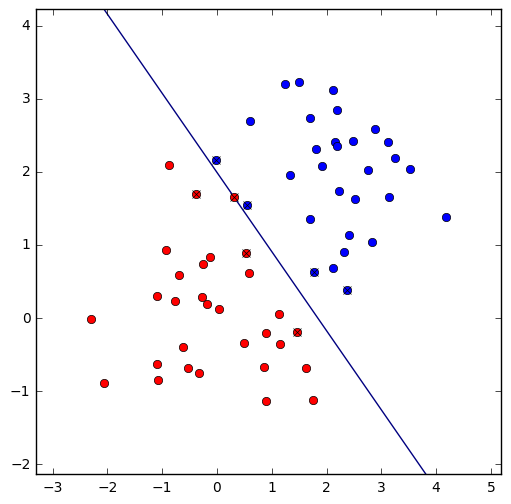

In [39]:
plot_svm_2d(X_tr, Y_tr, C)

In [60]:
a = np.linspace(-3,3,90)
b = np.linspace(-3,3,90)
A, B = np.meshgrid(x,y)
Z = [[a,b] for (a,b) in zip(A,B)]
Z = [C.fx(np.append(a.reshape(len(a),1),b.reshape(len(b),1),1),C.SV,C.y).T for (a,b) in zip(A,B)]

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [61]:
print(X)
print(Y)

[[-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 ..., 
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]
 [-3.         -2.93258427 -2.86516854 ...,  2.86516854  2.93258427  3.        ]]
[[-3.         -3.         -3.         ..., -3.         -3.         -3.        ]
 [-2.93258427 -2.93258427 -2.93258427 ..., -2.93258427 -2.93258427
  -2.93258427]
 [-2.86516854 -2.86516854 -2.86516854 ..., -2.86516854 -2.86516854
  -2.86516854]
 ..., 
 [ 2.86516854  2.86516854  2.86516854 ...,  2.86516854  2.86516854
   2.86516854]
 [ 2.93258427  2.93258427  2.93258427 ...,  2.93258427  2.93258427
   2.93258427]
 [ 3.          3.          3.         ...,  3.          3.          3.        ]]


In [62]:
Z[0]

array([[ 6.47546081,  6.4022495 ,  6.32903819,  6.25582688,  6.18261557,
         6.10940426,  6.03619295,  5.96298164,  5.88977033,  5.81655902,
         5.74334771,  5.67013641,  5.5969251 ,  5.52371379,  5.45050248,
         5.37729117,  5.30407986,  5.23086855,  5.15765724,  5.08444593,
         5.01123462,  4.93802331,  4.864812  ,  4.79160069,  4.71838938,
         4.64517807,  4.57196676,  4.49875545,  4.42554415,  4.35233284,
         4.27912153,  4.20591022,  4.13269891,  4.0594876 ,  3.98627629,
         3.91306498,  3.83985367,  3.76664236,  3.69343105,  3.62021974,
         3.54700843,  3.47379712,  3.40058581,  3.3273745 ,  3.2541632 ,
         3.18095189,  3.10774058,  3.03452927,  2.96131796,  2.88810665,
         2.81489534,  2.74168403,  2.66847272,  2.59526141,  2.5220501 ,
         2.44883879,  2.37562748,  2.30241617,  2.22920486,  2.15599355,
         2.08278224,  2.00957094,  1.93635963,  1.86314832,  1.78993701,
         1.7167257 ,  1.64351439,  1.57030308,  1.4

In [51]:
C.SV.shape

(1, 2)

In [50]:
C.alpha

array([ 0.45675652])

In [11]:
class SVMTrainer(object):
    def __init__(self, kernel, c):
        self._kernel = kernel
        self._c = c

    def train(self, X, y):
        """Given the training features X with labels y, returns a SVM
        predictor representing the trained SVM.
        """
        lagrange_multipliers = self._compute_multipliers(X, y)
        return self._construct_predictor(X, y, lagrange_multipliers)

    def _gram_matrix(self, X):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        # TODO(tulloch) - vectorize
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        support_vector_indices = \
            lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        # http://www.cs.cmu.edu/~guestrin/Class/10701-S07/Slides/kernels.pdf
        # bias = y_k - \sum z_i y_i  K(x_k, x_i)
        # Thus we can just predict an example with bias of zero, and
        # compute error.
        bias = np.mean(
            [y_k - SVMPredictor(
                kernel=self._kernel,
                bias=0.0,
                weights=support_multipliers,
                support_vectors=support_vectors,
                support_vector_labels=support_vector_labels).predict(x_k)
             for (y_k, x_k) in zip(support_vector_labels, support_vectors)])

        return SVMPredictor(
            kernel=self._kernel,
            bias=bias,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels)

    def _compute_multipliers(self, X, y):
        n_samples, n_features = X.shape

        K = self._gram_matrix(X)
        # Solves
        # min 1/2 x^T P x + q^T x
        # s.t.
        #  Gx \coneleq h
        #  Ax = b

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))

        # -a_i \leq 0
        # TODO(tulloch) - modify G, h so that we have a soft-margin classifier
        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_std = cvxopt.matrix(np.zeros(n_samples))

        # a_i \leq c
        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)

        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))

        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        return np.ravel(solution['x'])

In [ ]:
class SVMPredictor(object):
    def __init__(self,
                 kernel,
                 bias,
                 weights,
                 support_vectors,
                 support_vector_labels):
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels

    def predict(self, x):
        """
        Computes the SVM prediction on the given features x.
        """
        result = self._bias
        for z_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += z_i * y_i * self._kernel(x_i, x)
        return np.sign(result).item()
    
import numpy as np
import numpy.linalg as la


class Kernel(object):
    """Implements list of kernels from
    http://en.wikipedia.org/wiki/Support_vector_machine
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.inner(x, y)
        return f

    @staticmethod
    def gaussian(sigma):
        def f(x, y):
            exponent = -np.sqrt(la.norm(x-y) ** 2 / (2 * sigma ** 2))
            return np.exp(exponent)
        return f

    @staticmethod
    def _polykernel(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._polykernel(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._polykernel(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f